In [1]:
cd ..

/media/hjp/FAAC278CAC27430D/HJP/KUAICV/Hand/AbsoluteTrack


In [2]:
pwd

'/media/hjp/FAAC278CAC27430D/HJP/KUAICV/Hand/AbsoluteTrack'

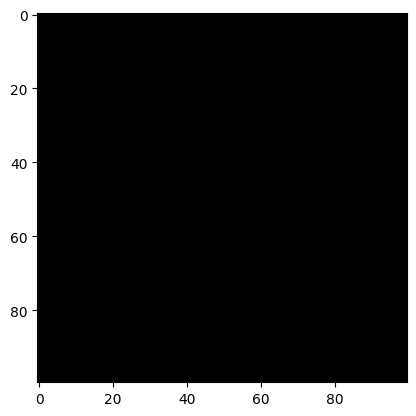

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


img = np.zeros((100, 100), dtype=np.uint8)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [4]:
# LICENSE file in the root directory of this source tree.

import os

import av
import fnmatch
import pickle
import numpy as np
import torch

import lib.data_utils.fs as fs

from functools import partial

# from lib.tracker.perspective_crop import landmarks_from_hand_pose


#from multiprocessing import Pool
#from typing import Optional, Tuple

from lib.models.model_loader import load_pretrained_model

#from lib.tracker.tracker import HandTracker, HandTrackerOpts, InputFrame, ViewData
from lib.tracker.video_pose_data import SyncedImagePoseStream

from typing import Dict, NamedTuple

#from lib.common.hand import NUM_HANDS, NUM_LANDMARKS_PER_HAND
NUM_HANDS = 2
NUM_LANDMARKS_PER_HAND = 21
NUM_FINGERTIPS_PER_HAND = 5
NUM_JOINTS_PER_HAND = 22
LEFT_HAND_INDEX = 0
RIGHT_HAND_INDEX = 1

NUM_DIGITS: int = 5
NUM_JOINT_FRAMES: int = 1 + 1 + 3 * 5  # root + wrist + finger frames * 5
DOF_PER_FINGER: int = 4

# import from lib.common.crop.py

In [5]:

from typing import Tuple

import lib.common.camera as camera
import numpy as np

#from . import affine
import lib.common.affine as affine


def gen_intrinsics_from_bounding_pts(
    pts_eye: np.ndarray, image_w: int, image_h: int, min_focal: float = 5
) -> Tuple[np.ndarray, np.ndarray]:
    pts_ndc = pts_eye[..., 0:2] / pts_eye[..., 2:]
    img_size = np.array([image_w, image_h], dtype=pts_eye.dtype)
    # Given our convention, we need to shift one pixel before dividing by 2.
    cx_cy = (img_size - 1) / 2
    fx_fy = cx_cy / np.absolute(pts_ndc).max()

    # Some sanity checks
    if np.any(pts_eye[..., 2:] < 0.0001) or np.any(fx_fy < min_focal):
        raise ValueError("Unable to create crop camera", fx_fy)

    return fx_fy, cx_cy


def gen_crop_parameters_from_points(
    camera_orig: camera.CameraModel,
    pts_world,
    new_image_size: Tuple[int, int],
    mirror_img_x: bool,
    camera_angle: float = 0,
    focal_multiplier: float = 0.95,
) -> camera.PinholePlaneCameraModel:
    """
    Given the original camera transform and a list of 3D points in the world space,
    compute the new perspective camera that makes sure after projection all the points
    can be projected inside the image.

    Auguments:
    * camera_orig: the original camera used for generating an image. The returned camera
        will have the same position but different rotation and intrinsics parameters.
    * pts_world: points in the world space that must be projected inside the image by
        the generated world to eye transform and intrinsics.
    * new_image_size: target image size
    * mirror_img_x: whether to flip the image. A typical use case is we usually mirror the
        right hand images so that a model need to handle left hand data only
    * camera_angle: how the camera is oriented physically so that we can rotate the object of
        interest to the 'upright' direction
    * focal_multiplier: when less than 1, we are zooming out a little. The effect on the image
        is some margin will be left at the boundary.
    """
    orig_world_to_eye_xf = np.linalg.inv(camera_orig.camera_to_world_xf)

    crop_center = (pts_world.min(axis=0) + pts_world.max(axis=0)) / 2.0
    new_world_to_eye = affine.make_look_at_matrix(
        orig_world_to_eye_xf, crop_center, camera_angle
    )
    if mirror_img_x:
        mirrorx = np.eye(4, dtype=np.float32)
        mirrorx[0, 0] = -1
        new_world_to_eye = mirrorx @ new_world_to_eye

    fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
        affine.transform3(new_world_to_eye, pts_world),
        new_image_size[0],
        new_image_size[1],
    )
    fx_fy = focal_multiplier * fx_fy

    return camera.PinholePlaneCameraModel(
        width=new_image_size[0],
        height=new_image_size[1],
        f=fx_fy,
        c=cx_cy,
        distort_coeffs=[],
        camera_to_world_xf=np.linalg.inv(new_world_to_eye),
    )


# import from lib.tracker.tracking_result 

In [6]:
from typing import Dict, NamedTuple

class SingleHandPose(NamedTuple):
    """
    A hand pose is composed of two fields:
    1) joint angles where # joints == # DoFs
    2) root-to-world rigid wrist transformation
    """

    joint_angles: np.ndarray = np.zeros(NUM_JOINTS_PER_HAND, dtype=np.float32)
    wrist_xform: np.ndarray = np.eye(4, dtype=np.float32)
    hand_confidence: float = 1.0


# Tracking result maps from hand_index to hand_pose
class TrackingResult(NamedTuple):
    hand_poses: Dict[int, SingleHandPose] = {}
    num_views: Dict[int, int] = {}
    predicted_scales: Dict[int, float] = {}


# import from lib.common.crop

In [7]:

from typing import Tuple

import lib.common.camera as camera
import lib.common.affine as affine

import numpy as np

# from . import affine


def gen_intrinsics_from_bounding_pts(
    pts_eye: np.ndarray, image_w: int, image_h: int, min_focal: float = 5
) -> Tuple[np.ndarray, np.ndarray]:
    pts_ndc = pts_eye[..., 0:2] / pts_eye[..., 2:]
    img_size = np.array([image_w, image_h], dtype=pts_eye.dtype)
    # Given our convention, we need to shift one pixel before dividing by 2.
    cx_cy = (img_size - 1) / 2
    fx_fy = cx_cy / np.absolute(pts_ndc).max()

    # Some sanity checks
    if np.any(pts_eye[..., 2:] < 0.0001) or np.any(fx_fy < min_focal):
        raise ValueError("Unable to create crop camera", fx_fy)

    return fx_fy, cx_cy


def gen_crop_parameters_from_points(
    camera_orig: camera.CameraModel,
    pts_world,
    new_image_size: Tuple[int, int],
    mirror_img_x: bool,
    camera_angle: float = 0,
    focal_multiplier: float = 0.95,
) -> camera.PinholePlaneCameraModel:
    """
    Given the original camera transform and a list of 3D points in the world space,
    compute the new perspective camera that makes sure after projection all the points
    can be projected inside the image.

    Auguments:
    * camera_orig: the original camera used for generating an image. The returned camera
        will have the same position but different rotation and intrinsics parameters.
    * pts_world: points in the world space that must be projected inside the image by
        the generated world to eye transform and intrinsics.
    * new_image_size: target image size
    * mirror_img_x: whether to flip the image. A typical use case is we usually mirror the
        right hand images so that a model need to handle left hand data only
    * camera_angle: how the camera is oriented physically so that we can rotate the object of
        interest to the 'upright' direction
    * focal_multiplier: when less than 1, we are zooming out a little. The effect on the image
        is some margin will be left at the boundary.
    """
    orig_world_to_eye_xf = np.linalg.inv(camera_orig.camera_to_world_xf)

    crop_center = (pts_world.min(axis=0) + pts_world.max(axis=0)) / 2.0
    new_world_to_eye = affine.make_look_at_matrix(
        orig_world_to_eye_xf, crop_center, camera_angle
    )
    if mirror_img_x:
        mirrorx = np.eye(4, dtype=np.float32)
        mirrorx[0, 0] = -1
        new_world_to_eye = mirrorx @ new_world_to_eye

    fx_fy, cx_cy = gen_intrinsics_from_bounding_pts(
        affine.transform3(new_world_to_eye, pts_world),
        new_image_size[0],
        new_image_size[1],
    )
    fx_fy = focal_multiplier * fx_fy

    return camera.PinholePlaneCameraModel(
        width=new_image_size[0],
        height=new_image_size[1],
        f=fx_fy,
        c=cx_cy,
        distort_coeffs=[],
        camera_to_world_xf=np.linalg.inv(new_world_to_eye),
    )


# import from lib.tracker.perspective_crop.py

In [8]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

from typing import Dict, List, Optional, Tuple

import lib.common.camera as camera
import numpy as np
import torch
#from lib.common.crop import gen_crop_parameters_from_points
from lib.common.hand import HandModel, NUM_JOINTS_PER_HAND, RIGHT_HAND_INDEX
from lib.common.hand_skinning import skin_landmarks

#from .tracking_result import SingleHandPose


def neutral_joint_angles(up: HandModel, lower_factor: float = 0.5) -> torch.Tensor:
    joint_limits = up.joint_limits
    assert joint_limits is not None
    return joint_limits[..., 0] * lower_factor + joint_limits[..., 1] * (
        1 - lower_factor
    )


def skin_landmarks_np(
    hand_model: HandModel,
    joint_angles: np.ndarray,
    wrist_transforms: np.ndarray,
) -> np.ndarray:
    landmarks = skin_landmarks(
        hand_model,
        torch.from_numpy(joint_angles).float(),
        torch.from_numpy(wrist_transforms).float(),
    )
    return landmarks.numpy()


def landmarks_from_hand_pose(
    hand_model: HandModel, hand_pose: SingleHandPose, hand_idx: int
) -> np.ndarray:
    """
    Compute 3D landmarks in the world space given the hand model and hand pose.
    """
    xf = hand_pose.wrist_xform.copy()
    # This function expects the user hand model to be a left hand.
    if hand_idx == RIGHT_HAND_INDEX:
        xf[:, 0] *= -1
    landmarks = skin_landmarks_np(hand_model, hand_pose.joint_angles, xf)
    return landmarks


def rank_hand_visibility_in_cameras(
    cameras: List[camera.CameraModel],
    hand_model: HandModel,
    hand_pose: SingleHandPose,
    hand_idx: int,
    min_required_vis_landmarks: int,
) -> List[int]:
    landmarks_world = landmarks_from_hand_pose(hand_model, hand_pose, hand_idx)
    n_landmarks_in_view = []
    ranked_cam_indices = []
    for cam_idx, camera in enumerate(cameras):
        landmarks_eye = camera.world_to_eye(landmarks_world)
        landmarks_win2 = camera.eye_to_window(landmarks_eye)

        n_visible = (
            (landmarks_win2[..., 0] >= 0)
            & (landmarks_win2[..., 0] <= camera.width - 1)
            & (landmarks_win2[..., 1] >= 0)
            & (landmarks_win2[..., 1] <= camera.height - 1)
            & (landmarks_eye[..., 2] > 0)
        ).sum()

        n_landmarks_in_view.append(n_visible)
        # Only push the cameras that can see enough hand points
        if n_visible >= min_required_vis_landmarks:
            ranked_cam_indices.append(cam_idx)

    #  Favor the view that sees more landmarks
    ranked_cam_indices.sort(
        reverse=True,
        key=lambda x: n_landmarks_in_view[x],
    )
    return ranked_cam_indices


def _get_crop_points_from_hand_pose(
    hand_model: HandModel,
    gt_hand_pose: SingleHandPose,
    hand_idx: int,
    num_crop_points: int,
) -> np.ndarray:
    '''
    args :
        hand_model : HandModel
        
        gt_hand_pose : SingleHandPose
        
        hand_idx : int

        num_crop_points : int
            ㅅㅂ WTF does num_crop_points do?
    
    return :
        np.ndarray of shape (num_crop_points, 3)
        each row is a 3D keypoint in the 3D coordinate
        (not sure world space or eye space)
    '''
    assert num_crop_points in [21, 42, 63]
    neutral_hand_pose = SingleHandPose(
        joint_angles=neutral_joint_angles(hand_model).numpy(),
        wrist_xform=gt_hand_pose.wrist_xform,
    )
    open_hand_pose = SingleHandPose(
        joint_angles=np.zeros(NUM_JOINTS_PER_HAND, dtype=np.float32),
        wrist_xform=gt_hand_pose.wrist_xform,
    )

    crop_points = []
    crop_points.append(landmarks_from_hand_pose(
        hand_model, gt_hand_pose, hand_idx)
    )
    if num_crop_points > 21:
        crop_points.append(
            landmarks_from_hand_pose(
                hand_model, neutral_hand_pose, hand_idx
            )
        )
    if num_crop_points > 42:
        crop_points.append(
            landmarks_from_hand_pose(
                hand_model, open_hand_pose, hand_idx
            )
        )
    
    result = np.concatenate(crop_points, axis=0)
    print("crop_points", result.shape)
    
    return result

def gen_crop_cameras_from_pose(
    cameras: List[camera.CameraModel],
    camera_angles: List[float],
    hand_model: HandModel,
    hand_pose: SingleHandPose,
    hand_idx: int,
    num_crop_points: int,
    new_image_size: Tuple[int, int],
    max_view_num: Optional[int] = None,
    sort_camera_index: bool = False,
    focal_multiplier: float = 0.95,
    mirror_right_hand: bool = True,
    min_required_vis_landmarks: int = 19,
) -> Dict[int, camera.PinholePlaneCameraModel]:
    
    
    crop_cameras: Dict[int, camera.PinholePlaneCameraModel] = {}
    crop_points = _get_crop_points_from_hand_pose(
        hand_model,
        hand_pose,
        hand_idx,
        num_crop_points,
    )
    

    
    cam_indices = rank_hand_visibility_in_cameras(
        cameras=cameras,
        hand_model=hand_model,
        hand_pose=hand_pose,
        hand_idx=hand_idx,
        min_required_vis_landmarks=min_required_vis_landmarks,
    )

    if sort_camera_index:
        cam_indices = sorted(cam_indices)

    for cam_idx in cam_indices:
        crop_cameras[cam_idx] = gen_crop_parameters_from_points(
            cameras[cam_idx],
            crop_points,
            new_image_size,
            mirror_img_x=(mirror_right_hand and hand_idx == 1),
            camera_angle=camera_angles[cam_idx],
            focal_multiplier=focal_multiplier,
        )
        if len(crop_cameras) == max_view_num:
            break

    return crop_cameras


# import from tracker.py

In [9]:
# tracker.py

from dataclasses import dataclass
from typing import Dict, List, Optional

import cv2

import lib.common.camera as camera
import numpy as np
import torch


from lib.common.hand import HandModel, NUM_HANDS, scaled_hand_model

from lib.data_utils import bundles

from lib.models.regressor import RegressorOutput
from lib.models.umetrack_model import InputFrameData, InputFrameDesc, InputSkeletonData


MM_TO_M = 0.001
M_TO_MM = 1000.0
MIN_OBSERVED_LANDMARKS = 21
CONFIDENCE_THRESHOLD = 0.5
MAX_VIEW_NUM = 2


@dataclass
class ViewData:
    image: np.ndarray
    camera: camera.CameraModel
    camera_angle: float


@dataclass
class InputFrame:
    views: List[ViewData]

@dataclass
class HandTrackerOpts:
    
    num_crop_points: int = 63
    # can be [21, 42, 63]
    # when performing perspective crop,
    # 21: crop along detected pose ?
    # 42: crop along detected pose + open pose
    # 63: crop along detected pose + open pose + neutral pose
    
    enable_memory: bool = True
    
    use_stored_pose_for_crop: bool = True
    
    hand_ratio_in_crop: float = 0.95
    
    min_required_vis_landmarks: int = 19

def _warp_image(
    src_camera: camera.CameraModel,
    dst_camera: camera.CameraModel,
    src_image: np.ndarray,
    interpolation: int = cv2.INTER_LINEAR,
    depth_check: bool = True,
) -> np.ndarray:
    W, H = dst_camera.width, dst_camera.height
    px, py = np.meshgrid(np.arange(W), np.arange(H))
    dst_win_pts = np.column_stack((px.flatten(), py.flatten()))

    dst_eye_pts = dst_camera.window_to_eye(dst_win_pts)
    world_pts = dst_camera.eye_to_world(dst_eye_pts)
    src_eye_pts = src_camera.world_to_eye(world_pts)
    src_win_pts = src_camera.eye_to_window(src_eye_pts)

    # Mask out points with negative z coordinates
    if depth_check:
        mask = src_eye_pts[:, 2] < 0
        src_win_pts[mask] = -1

    src_win_pts = src_win_pts.astype(np.float32)

    map_x = src_win_pts[:, 0].reshape((H, W))
    map_y = src_win_pts[:, 1].reshape((H, W))

    return cv2.remap(src_image, map_x, map_y, interpolation)

class HandTracker:
    def __init__(self, model, opts: HandTrackerOpts) -> None:
        self._device: str = "cuda" if torch.cuda.device_count() else "cpu"
        
        self._model = model
        self._model.to(self._device)

        self._input_size = np.array(self._model.getInputImageSizes())
        self._num_crop_points = opts.num_crop_points
        self._enable_memory = opts.enable_memory
        self._hand_ratio_in_crop: float = opts.hand_ratio_in_crop
        self._min_required_vis_landmarks: int = opts.min_required_vis_landmarks
        self._valid_tracking_history = np.zeros(2, dtype=bool)

    def reset_history(self) -> None:
        self._valid_tracking_history[:] = False

    def gen_crop_cameras(
        self,
        cameras: List[camera.CameraModel],
        camera_angles: List[float],
        hand_model: HandModel,
        gt_tracking: Dict[int, SingleHandPose],
        min_num_crops: int,
    ) -> Dict[int, Dict[int, camera.PinholePlaneCameraModel]]:
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]] = {}
        if not gt_tracking:
            return crop_cameras

        for hand_idx, gt_hand_pose in gt_tracking.items():
            if gt_hand_pose.hand_confidence < CONFIDENCE_THRESHOLD:
                continue
            crop_cameras[hand_idx] = gen_crop_cameras_from_pose(
                cameras,
                camera_angles,
                hand_model,
                gt_hand_pose,
                hand_idx,
                self._num_crop_points,
                self._input_size,
                max_view_num=MAX_VIEW_NUM,
                sort_camera_index=True,
                focal_multiplier=self._hand_ratio_in_crop,
                mirror_right_hand=True,
                min_required_vis_landmarks=self._min_required_vis_landmarks,
            )

        # Remove empty crop_cameras
        del_list = []
        for hand_idx, per_hand_crop_cameras in crop_cameras.items():
            if not per_hand_crop_cameras or len(per_hand_crop_cameras) < min_num_crops:
                del_list.append(hand_idx)
        for hand_idx in del_list:
            del crop_cameras[hand_idx]

        return crop_cameras

    def track_frame(
        self,
        sample: InputFrame,
        hand_model: HandModel,
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]],
    ) -> TrackingResult:
        if not crop_cameras:
            # Frame without hands
            self.reset_history()
            return TrackingResult()

        frame_data, frame_desc, skeleton_data = self._make_inputs(
            sample, hand_model, crop_cameras
        )
        with torch.no_grad():
            regressor_output = bundles.to_device(
                self._model.regress_pose_use_skeleton(
                    frame_data, frame_desc, skeleton_data
                ),
                torch.device("cpu"),
            )

        tracking_result = self._gen_tracking_result(
            regressor_output,
            frame_desc.hand_idx.cpu().numpy(),
            crop_cameras,
        )
        return tracking_result

    def track_frame_and_calibrate_scale(
        self,
        sample: InputFrame,
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]],
    ) -> TrackingResult:
        if not crop_cameras:
            # Frame without hands
            self.reset_history()
            return TrackingResult()
        frame_data, frame_desc, _ = self._make_inputs(sample, None, crop_cameras)

        with torch.no_grad():
            regressor_output = bundles.to_device(
                self._model.regress_pose_pred_skel_scale(frame_data, frame_desc),
                torch.device("cpu"),
            )

        tracking_result = self._gen_tracking_result(
            regressor_output,
            frame_desc.hand_idx.cpu().numpy(),
            crop_cameras,
        )
        return tracking_result

    def _make_inputs(
        self,
        sample: InputFrame,
        hand_model_mm: Optional[HandModel],
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]],
    ):
        image_idx = 0
        left_images = []
        intrinsics = []
        extrinsics_xf = []
        sample_range_n_hands = []
        hand_indices = []
        for hand_idx, crop_camera_info in crop_cameras.items():
            sample_range_start = image_idx
            for cam_idx, crop_camera in crop_camera_info.items():
                view_data = sample.views[cam_idx]
                crop_image = _warp_image(view_data.camera, crop_camera, view_data.image)
                left_images.append(crop_image.astype(np.float32) / 255.0)
                intrinsics.append(crop_camera.uv_to_window_matrix())

                crop_world_to_eye_xf = np.linalg.inv(crop_camera.camera_to_world_xf)
                crop_world_to_eye_xf[:3, 3] *= MM_TO_M
                extrinsics_xf.append(crop_world_to_eye_xf)

                image_idx += 1

            if image_idx > sample_range_start:
                hand_indices.append(hand_idx)
                sample_range_n_hands.append(np.array([sample_range_start, image_idx]))

        hand_indices = np.array(hand_indices)
        frame_data = InputFrameData(
            left_images=torch.from_numpy(np.stack(left_images)).float(),
            intrinsics=torch.from_numpy(np.stack(intrinsics)).float(),
            extrinsics_xf=torch.from_numpy(np.stack(extrinsics_xf)).float(),
        )
        frame_desc = InputFrameDesc(
            sample_range=torch.from_numpy(np.stack(sample_range_n_hands)).long(),
            memory_idx=torch.from_numpy(hand_indices).long(),
            # use memory if the hand is previously valid
            use_memory=torch.from_numpy(
                self._valid_tracking_history[hand_indices]
            ).bool(),
            hand_idx=torch.from_numpy(hand_indices).long(),
        )
        skeleton_data = None
        if hand_model_mm is not None:
            # m -> mm
            hand_model_m = scaled_hand_model(hand_model_mm, MM_TO_M)
            skeleton_data = InputSkeletonData(
                joint_rotation_axes=hand_model_m.joint_rotation_axes.float(),
                joint_rest_positions=hand_model_m.joint_rest_positions.float(),
            )
        return bundles.to_device((frame_data, frame_desc, skeleton_data), self._device)

    def _gen_tracking_result(
        self,
        regressor_output: RegressorOutput,
        hand_indices: np.ndarray,
        crop_cameras: Dict[int, Dict[int, camera.PinholePlaneCameraModel]],
    ) -> TrackingResult:

        output_joint_angles = regressor_output.joint_angles.to("cpu").numpy()
        output_wrist_xforms = regressor_output.wrist_xfs.to("cpu").numpy()
        output_wrist_xforms[..., :3, 3] *= M_TO_MM
        output_scales = None
        if regressor_output.skel_scales is not None:
            output_scales = regressor_output.skel_scales.to("cpu").numpy()

        hand_poses = {}
        num_views = {}
        predicted_scales = {}

        for output_idx, hand_idx in enumerate(hand_indices):
            raw_handpose = SingleHandPose(
                joint_angles=output_joint_angles[output_idx],
                wrist_xform=output_wrist_xforms[output_idx],
                hand_confidence=1.0,
            )
            hand_poses[hand_idx] = raw_handpose
            num_views[hand_idx] = len(crop_cameras[hand_idx])
            if output_scales is not None:
                predicted_scales[hand_idx] = output_scales[output_idx]

        for hand_idx in range(NUM_HANDS):
            hand_valid = False
            if hand_idx in hand_poses:
                self._valid_tracking_history[hand_idx] = True
                hand_valid = True
            if hand_valid:
                continue
            self._valid_tracking_history[hand_idx] = False

        return TrackingResult(
            hand_poses=hand_poses,
            num_views=num_views,
            predicted_scales=predicted_scales,
        )


In [10]:
import logging
import os

logging.basicConfig(level = logging.INFO)
logger = logging.getLogger(__name__)

model_name = "pretrained_weights.torch"
model_path = os.path.join(".", "pretrained_models", model_name)
model = load_pretrained_model(model_path)
model.eval()
tracker = HandTracker(model, HandTrackerOpts())

DATA_PATH = "sample_data/recording_00.mp4"
image_pose_stream = SyncedImagePoseStream(DATA_PATH)
hand_model = image_pose_stream._hand_pose_labels.hand_model

image_pose_list = []
for (input_frame, gt_tracking) in image_pose_stream:
    image_pose_list.append((input_frame, gt_tracking))

Opened (30 fps) video from sample_data/recording_00.mp4


# Parse and analyze GT annotatio

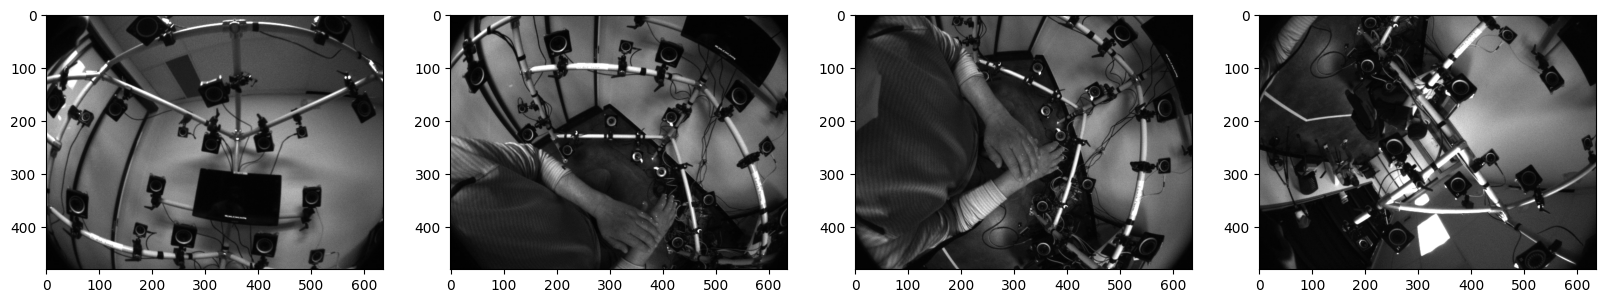

2 [-0.06204438  0.51745284  0.37440667  1.05211604 -0.25388715  0.30060542
  0.65520853  0.2746726  -0.18099593  0.34473345  0.6479342   0.31328049
 -0.05390345  0.13575022  0.6570453   0.37323809 -0.09756543 -0.02032871
  0.79338115  0.16147612  0.          0.        ]


In [24]:
idx = 20

input_frame, gt_tracking = image_pose_list[idx]

plt.figure(figsize=(20, 10))
for i, view in enumerate(input_frame.views):
    plt.subplot(1, len(input_frame.views), i+1)
    plt.imshow(view.image, cmap="gray")
plt.show()

print(len(gt_tracking), gt_tracking[0].joint_angles)

In [15]:
# Visualize camera's position and orientation in world coordinate system using plotly
import plotly.graph_objs as go
import numpy as np


def create_camera_visualization(camera_to_world_xf):
    # Extract camera position (translation)
    camera_pos = camera_to_world_xf[:3, 3]
    
    # Extract camera orientation (rotation)
    camera_x = camera_to_world_xf[:3, 0]
    camera_y = camera_to_world_xf[:3, 1]
    camera_z = camera_to_world_xf[:3, 2]
    
    # Create camera position marker
    camera_marker = go.Scatter3d(
        x=[camera_pos[0]], y=[camera_pos[1]], z=[camera_pos[2]],
        mode='markers',
        marker=dict(size=8, color='red'),
        name='Camera'
    )
    
    # Create camera orientation arrows
    scale = 10  # Scale factor for orientation arrows
    arrows = []
    for axis, color in zip([camera_x, camera_y, camera_z], ['red', 'green', 'blue']):
        arrows.append(go.Scatter3d(
            x=[camera_pos[0], camera_pos[0] + scale * axis[0]],
            y=[camera_pos[1], camera_pos[1] + scale * axis[1]],
            z=[camera_pos[2], camera_pos[2] + scale * axis[2]],
            mode='lines',
            line=dict(color=color, width=3),
            name=f'{color.capitalize()} axis'
        ))
    
    return [camera_marker] + arrows

# Create the main figure
fig = go.Figure()

# Add camera visualizations for each view
for i, view in enumerate(input_frame.views):
    camera_vis = create_camera_visualization(
        view.camera.camera_to_world_xf
    )
    for trace in camera_vis:
        fig.add_trace(trace)
    
    # print(f"Camera {i}:")
    # print(f"  Angle: {view.camera_angle}")
    # print(f"  Focal length: {view.camera.f}")
    # print(f"  Optical center: {view.camera.c}")
    # print(f"  Camera to world transform:\n{view.camera.camera_to_world_xf}")
    # print()

# Set layout
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    title="Camera Positions and Orientations in World Coordinate System",
    legend_title="Legend",
    height=800,
    width=1000
)

# Show the plot
fig.show()

In [23]:

for (input_frame, gt_tracking) in image_pose_list :
    # check if Z axis of second and third camera are parallel
    
    print(
        "cosine between Z axis of second and third camera : ",
        #np.sqrt(np.sum(np.square(input_frame.views[1].camera.camera_to_world_xf[:3, 2]))),
        #np.sqrt(np.sum(np.square(input_frame.views[2].camera.camera_to_world_xf[:3, 2]))),
        np.dot(
            input_frame.views[1].camera.camera_to_world_xf[:3, 2],
            input_frame.views[2].camera.camera_to_world_xf[:3, 2]
        )
    )
    
    
    print(
        "cosine between Z axis of first camera and second camera : ",
        np.dot(
            input_frame.views[0].camera.camera_to_world_xf[:3, 2],
            input_frame.views[1].camera.camera_to_world_xf[:3, 2]
        )
    )

    print(np.dot(
        np.cross(
            input_frame.views[0].camera.camera_to_world_xf[:3, 2],
            input_frame.views[1].camera.camera_to_world_xf[:3, 2],
        ),
        np.cross(
            input_frame.views[2].camera.camera_to_world_xf[:3, 2],
            input_frame.views[3].camera.camera_to_world_xf[:3, 2],
        )
    ))
    
    print()

cosine between Z axis of second and third camera :  0.93913318284371
cosine between Z axis of first camera and second camera :  0.10822279016363012
0.1863964763927823

cosine between Z axis of second and third camera :  0.9391330651068094
cosine between Z axis of first camera and second camera :  0.10822287864555946
0.18639641535815857

cosine between Z axis of second and third camera :  0.9391329347847919
cosine between Z axis of first camera and second camera :  0.10822285171015977
0.1863964362037213

cosine between Z axis of second and third camera :  0.9391332241952846
cosine between Z axis of first camera and second camera :  0.10822271227240421
0.18639644393317267

cosine between Z axis of second and third camera :  0.9391333840794266
cosine between Z axis of first camera and second camera :  0.10822274957475031
0.18639650326270205

cosine between Z axis of second and third camera :  0.9391331347045011
cosine between Z axis of first camera and second camera :  0.10822292074567219

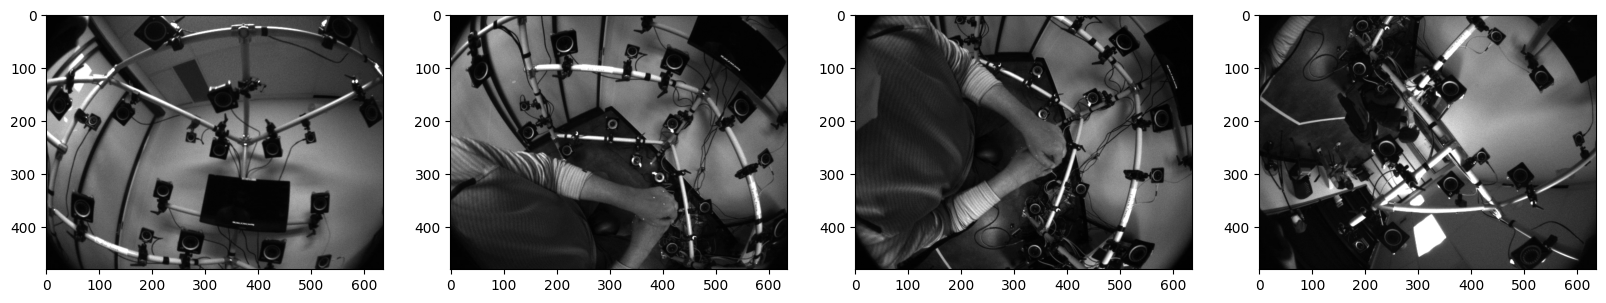

crop_points (63, 3)
crop_points (63, 3)


In [31]:

crop_cameras = tracker.gen_crop_cameras(
    [view.camera for view in input_frame.views],
    image_pose_stream._hand_pose_labels.camera_angles,
    hand_model,
    gt_tracking,
    min_num_crops=1,
)
#res = tracker.track_frame(input_frame, hand_model, crop_cameras)


In [16]:
res = tracker.track_frame(input_frame, hand_model, crop_cameras)

In [33]:
landmarks_from_hand_pose(hand_model, gt_tracking[0], 0)

array([[ 12.122704 , -32.361137 , 217.9637   ],
       [ 17.92804  , -69.88997  , 224.82623  ],
       [ 20.797867 , -80.622345 , 195.01395  ],
       [ 20.195038 , -72.334915 , 169.76819  ],
       [ 36.362755 , -46.32898  , 136.25134  ],
       [-19.958931 , -27.3629   ,  67.319565 ],
       [-21.476757 , -30.777569 , 164.72452  ],
       [ -4.810337 , -29.536852 , 199.8284   ],
       [ 12.824699 ,  -4.0142097, 174.74539  ],
       [ 32.504173 , -20.527899 , 208.04938  ],
       [ 23.387085 , -45.42784  , 216.27072  ],
       [ 35.20734  ,  -8.929182 , 162.41434  ],
       [ 55.349606 , -33.271183 , 197.39832  ],
       [ 34.09291  , -55.881233 , 192.61923  ],
       [ 49.428093 , -21.254494 , 146.59218  ],
       [ 67.87033  , -41.99452  , 179.54381  ],
       [ 43.92935  , -59.365463 , 175.87468  ],
       [ 56.807884 , -38.503777 , 128.08615  ],
       [ 69.89097  , -52.672325 , 154.4665   ],
       [ 49.1463   , -60.637726 , 152.3467   ],
       [ 16.525377 , -29.43506  , 154.99